<a href="https://colab.research.google.com/github/phelchegs/machine-learning-project-4/blob/main/ISYE6740_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install RDKit.
%%capture
!pip install rdkit-pypi

In [ ]:
#Import packages: rdkit, numpy, pandas, seaborn, matplotlib, and sklearn.

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA, KernelPCA

In [ ]:
#Import the dataset using pd.read_csv.

df = pd.read_csv('/ISYE6740_final project/curated-solubility-dataset.csv')

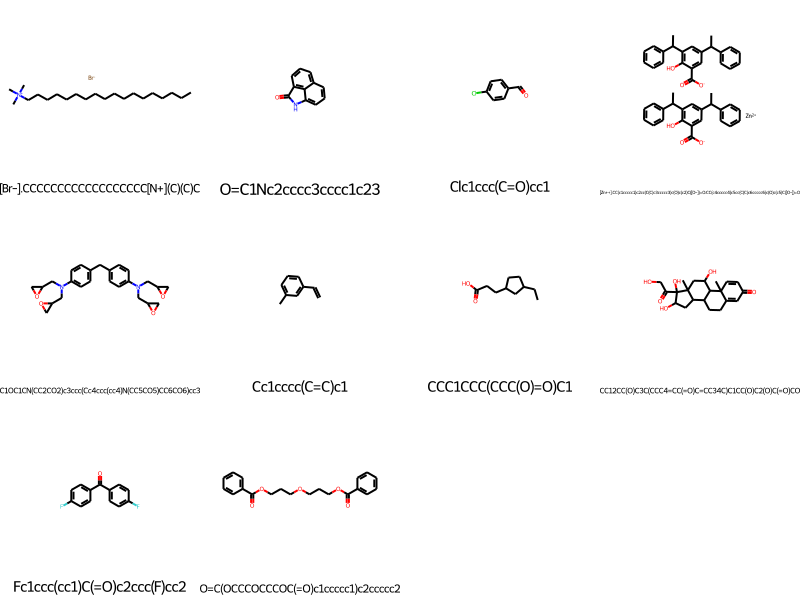

In [ ]:
#Molecular structures demonstration. Rdkit is really a good tool to convert SMILES to molecules' pictures.

df_demo = df.loc[:, ['SMILES']]
df_demo['MOL'] = df_demo['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))

#Show the first 10 molecules by first converting SMILES to MOL and then use .MolsToGridImage() to convert MOL to pics.

mols = df_demo['MOL'][:10]
Draw.MolsToGridImage(mols, molsPerRow = 4, useSVG = True, legends = list(df_demo['SMILES'][:10].values))

In [ ]:
#Look through the columns' names. Variables from ID to Group are string or identification variables. The dependent variable is Solubility.
#The other numeric variables are dependent variables.

df.columns.values

array(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR',
       'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms',
       'NumRotatableBonds', 'NumValenceElectrons', 'NumAromaticRings',
       'NumSaturatedRings', 'NumAliphaticRings', 'RingCount', 'TPSA',
       'LabuteASA', 'BalabanJ', 'BertzCT'], dtype=object)

In [ ]:
#As described in this blog http://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html, 
#AP, the aromatic proportion (number of aromatic atoms / total number of heavy atoms), is an important feature that contribute to LogS.
#Each aromatic ring corresponds to 6 aromatic atoms, arbitrarily. (? here. we can find a way to distinguish benzene/pyridine and pyrrole rings in the future.)
#Then the NumAromaticRings and HeavyAtomCount needs to be dropped.

df['AP'] = df['NumAromaticRings']*6/df['HeavyAtomCount']

#Also, drop the identification and string variables.

data = df.drop(['ID', 'InChI', 'InChIKey', 'Group', 'SD', 'Ocurrences', 'SMILES', 'Name', 'HeavyAtomCount', 'NumAromaticRings'], axis = 1)

In [ ]:
#Statistic summary of the feature-selected data. But I think that some features may be correlated with the others. For example, number of heteroatoms
#(NumHeteroatoms) should be proportional to number of H bond acceptors (NumHAcceptors), molecular weight (MolWt) should be proportional to number of 
#valence electrons (NumValenceElectrons) and number of heteroatoms (NumHeteroatoms).

data.describe()

,Solubility,MolWt,MolLogP,MolMR,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT,AP
count,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000
mean,-2.889909,266.665946,1.979167,66.794594,3.486776,1.108595,5.196955,4.073031,94.243438,0.292627,0.447606,1.515929,62.458601,108.912586,2.392199,467.336782,0.335247
std,2.368154,184.179024,3.517738,46.523021,3.498203,1.488973,4.736275,5.646925,64.748563,0.879599,1.054667,1.644334,63.348307,76.462726,1.091123,546.631696,0.330652
min,-13.171900,9.012000,-40.873200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.504228,-0.000004,0.000000,0.000000
25%,-4.326325,162.276000,0.619750,40.602475,2.000000,0.000000,3.000000,1.000000,58.000000,0.000000,0.000000,0.000000,26.300000,66.623721,2.004357,163.243343,0.000000
50%,-2.618173,228.682000,1.949220,58.633400,3.000000,1.000000,4.000000,3.000000,82.000000,0.000000,0.000000,1.000000,50.720000,93.299873,2.539539,351.640433,0.352941
75%,-1.209735,320.436000,3.419030,81.938000,4.000000,2.000000,6.000000,5.000000,112.000000,0.000000,1.000000,2.000000,80.390000,129.118374,3.032456,606.562848,0.571429
max,2.137682,5299.456000,68.541140,1419.351700,86.000000,26.000000,89.000000,141.000000,2012.000000,30.000000,30.000000,36.000000,1214.340000,2230.685124,7.517310,20720.267708,1.750000


In [ ]:
#Scale all the numeric features 1st and then perform covariance matrix and heatmap.

cols = list(data.columns.values)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

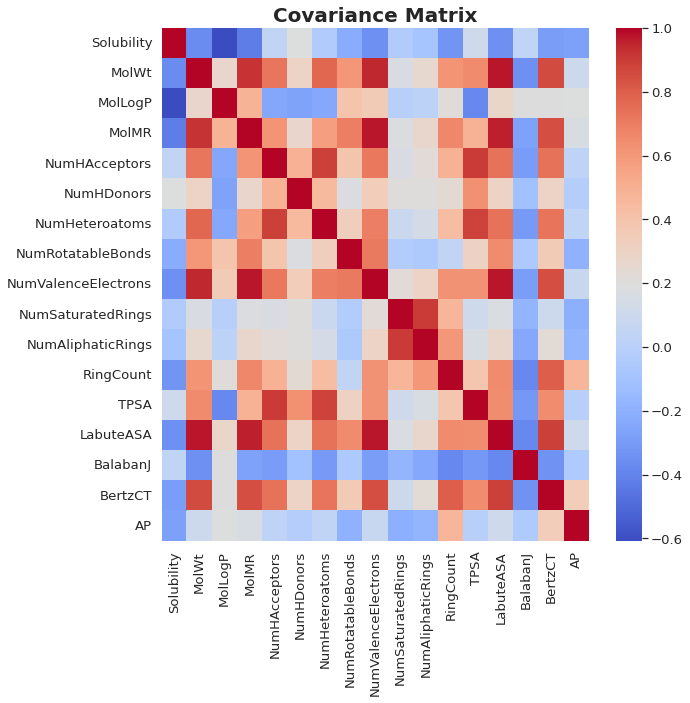

In [ ]:
#Covariance matrix

cov_mat =np.cov(data_scaled.T)
plt.figure(figsize = (10, 10))
sns.set(font_scale = 1.2)

#Heatmap

hm = sns.heatmap(cov_mat,
                 cbar = True,
                 cbar_kws = {"shrink": 1.0},
                 cmap = 'coolwarm',                 
                 yticklabels = cols,
                 xticklabels = cols)
plt.title('Covariance Matrix', fontweight = "bold", fontsize = 20)
plt.tight_layout()
plt.show()

In [ ]:
#Found that NumValenceElectrons, LabuteASA, and MolMR are correlated to MolWt. Keep MolWt since it is more general.
#Found that NumAliphaticRings is correlated to NumSaturatedRings. Keep NumSaturatedRings.
#Found that NumHAcceptors is correlated to NumHeteroatoms. Keep NumHeteroatoms.
#RingCount is correlated to NumSaturatedRings and NumAromaticRings (AP). Remove RingCount.
#TPSA is correlated to NumHAcceptors and NumHeteroatoms. Remove TPSA. (Polar surface area is proportional to number of heteroatoms.)

data = data.drop(['NumValenceElectrons', 'LabuteASA', 'MolMR', 'NumAliphaticRings', 'NumHAcceptors', 'RingCount', 'TPSA'], axis = 1)

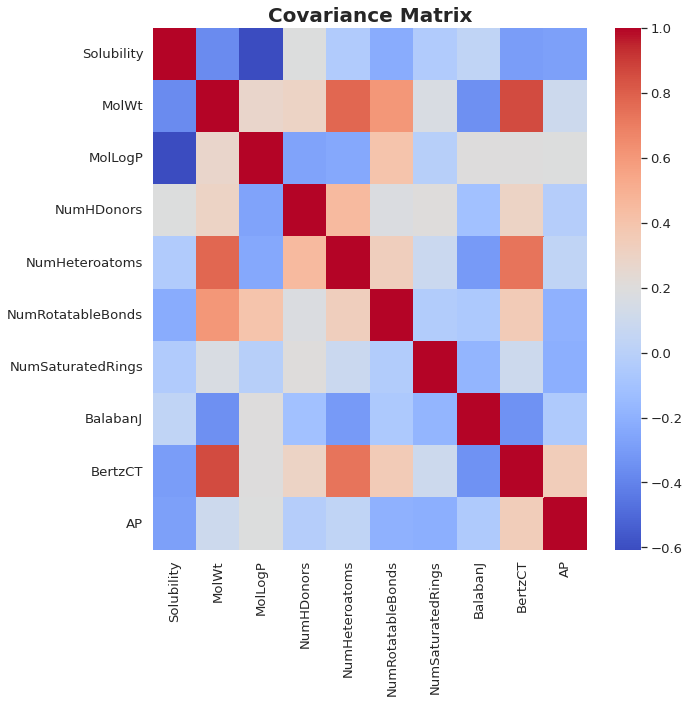

In [ ]:
#Check the covar and heatmap after removing the uninformative variables.
#Found that MolLogP is negatively correlated to Solubility. MolLogP is the partition coeff of a compound in octanol vs water,
#which directly indicates solubility. MolLogP is expected to contribute a lot for modelling.
#BertzCT is correlated to MolWt, but in the acceptable region. We keep BertzCT since we have already removed TPSA for topological features.

cols = list(data.columns.values)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
cov_mat =np.cov(data_scaled.T)
plt.figure(figsize = (10, 10))
hm = sns.heatmap(cov_mat,
                 cbar = True,
                 cbar_kws = {"shrink": 1.0},
                 cmap = 'coolwarm',                 
                 yticklabels = cols,
                 xticklabels = cols)
plt.title('Covariance Matrix', fontweight = "bold", fontsize = 20)
plt.tight_layout()
plt.show()

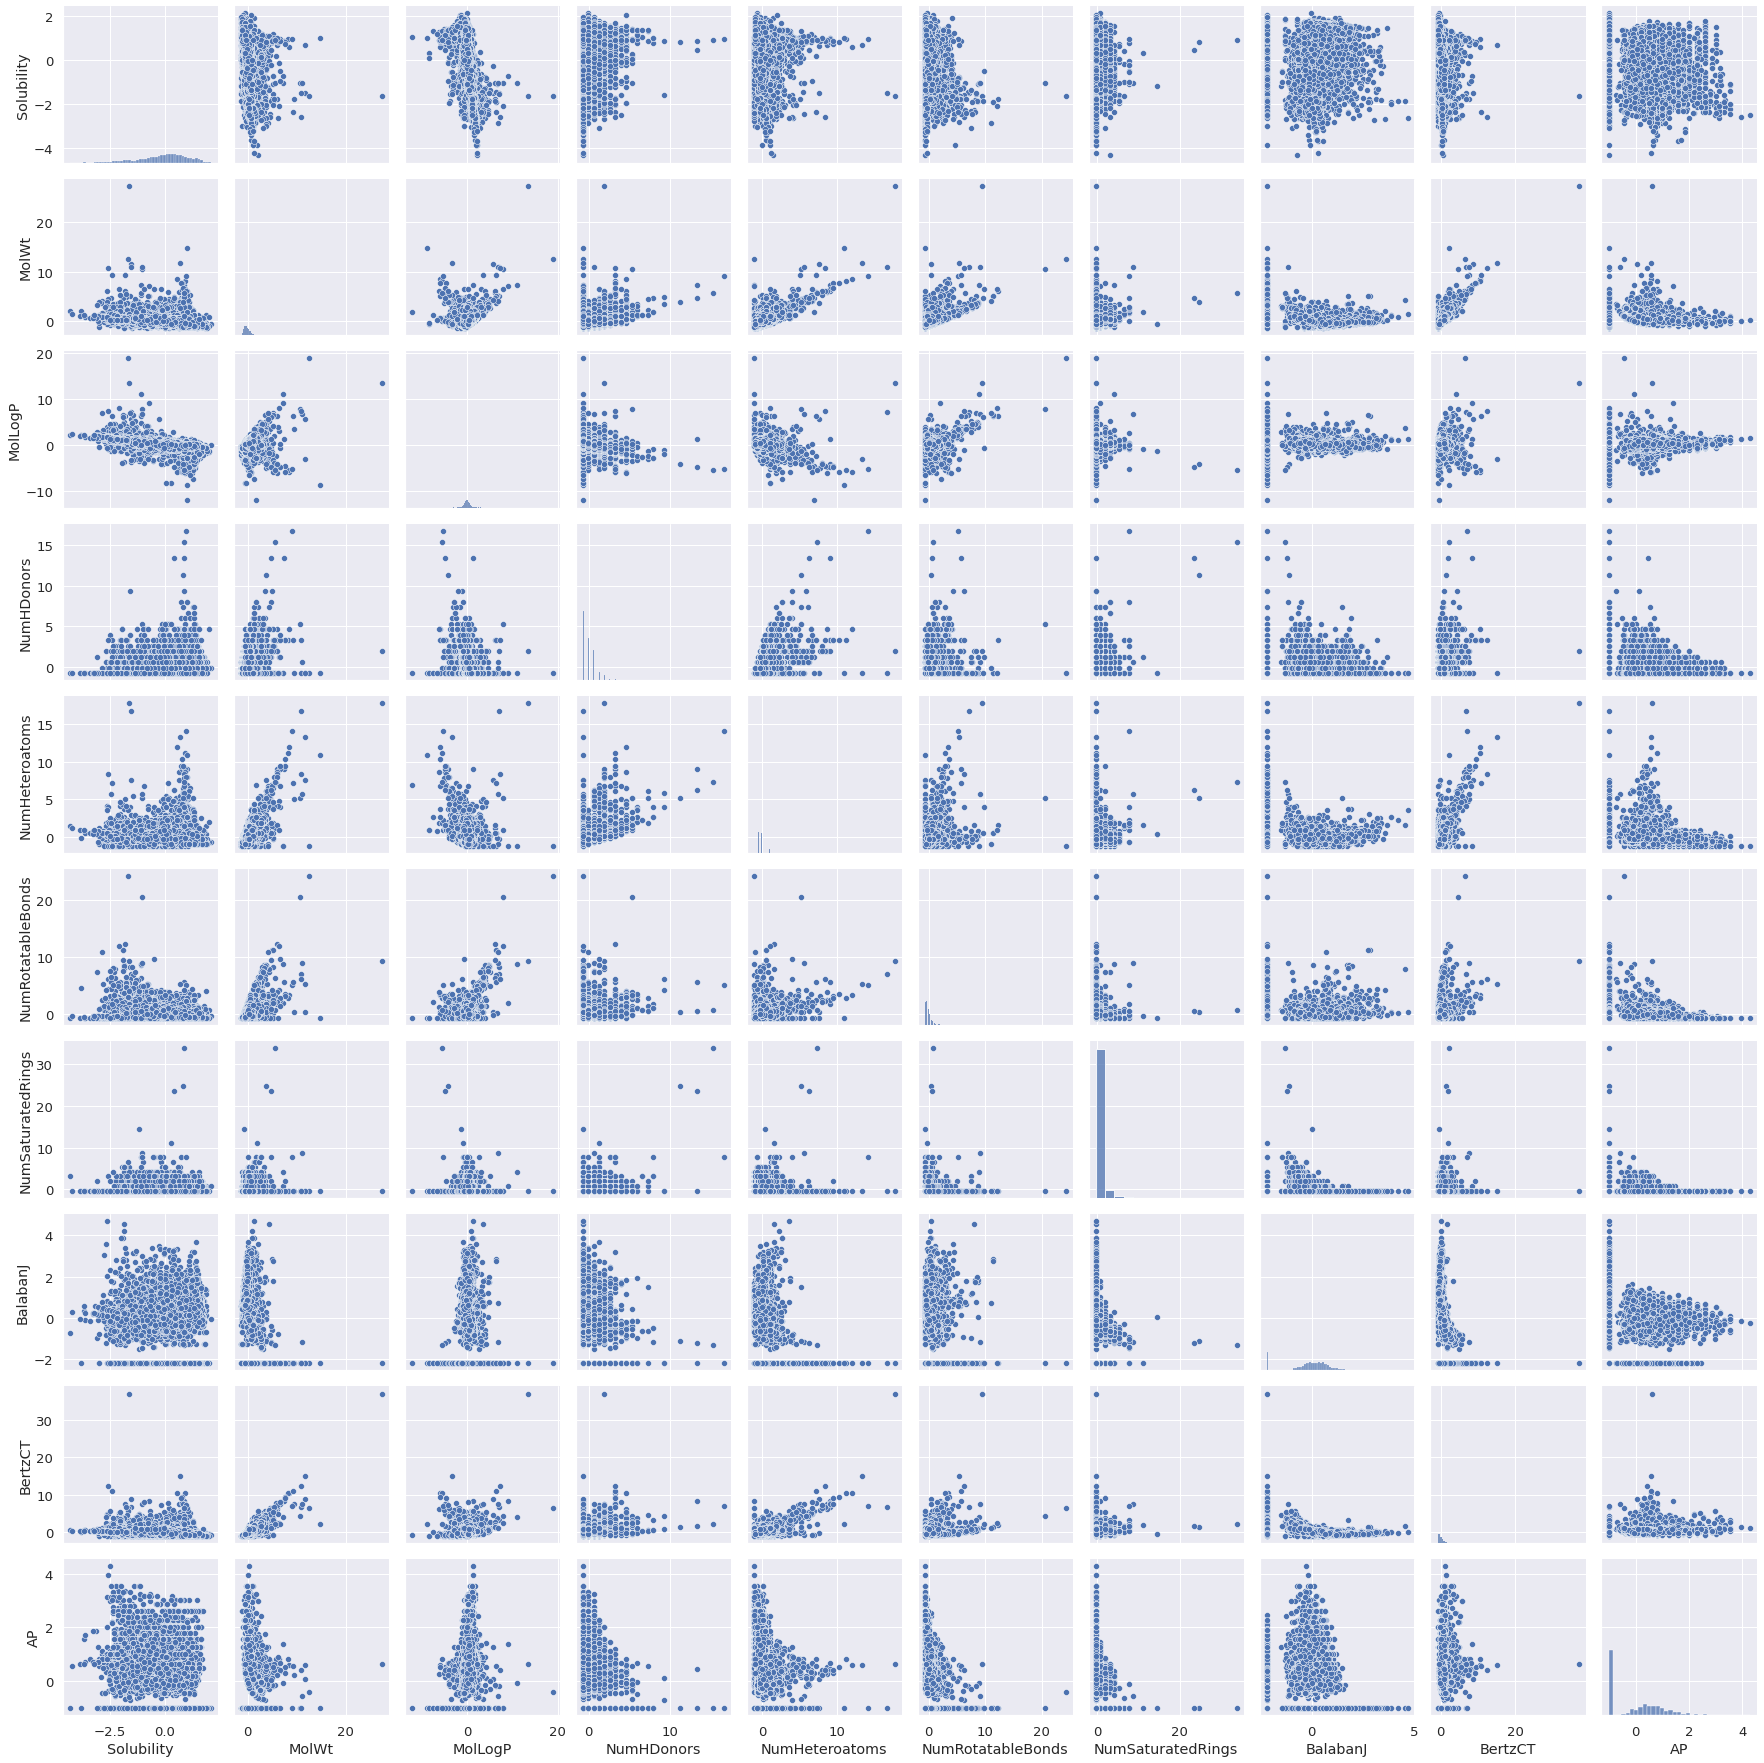

In [ ]:
#Pairplot.
#We observe the collinearity to some level between indepenent variables, for example, MolWt and BertzCT. But they are acceptable and we decide to 
#include them for now and let the model select features by hypertuning regularization coeffs later.

data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = cols
sns.pairplot(data_scaled)

In [ ]:
#Define the training/testing splitting function. Split the obs of each group (G1-G6) with the same chance and the same fraction.
#Because each group represents different reliability for data collection as stated in the original paper of AqSolDB (Sci. Data 2019, 6 (1), 143).

def split_mixed_group(data, cols, random_state):
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    for i in range(1, 6):
      data_grouped = data[data['Group'] == 'G{}'.format(i)]
      data_train = data_grouped.sample(frac = 0.8, random_state = random_state, axis = 0)
      data_test = data_grouped.loc[~data_grouped.index.isin(data_train.index)]
      X_train.append(data_train[cols[1:]])
      Y_train.append(data_train[cols[0]])
      X_test.append(data_test[cols[1:]])
      Y_test.append(data_test[cols[0]])
    X_trainset, Y_trainset, X_testset, Y_testset = pd.concat(X_train), pd.concat(Y_train), pd.concat(X_test), pd.concat(Y_test)
    return X_trainset, Y_trainset, X_testset, Y_testset

In [ ]:
#Split the dataset to training and testing sets.

X_trainset, Y_trainset, X_testset, Y_testset = split_mixed_group(df, cols, 1)

#Save the training and testing obs' indices to be used for demonstration of prediction accuracy at the end of each modelling.

train_indices = X_trainset.reset_index()[['index']]
test_indices = X_testset.reset_index()[['index']]

#Scale the independent variables for X training and X testing (using X_trainset's mean and std).

scaler2 = StandardScaler()
scaler2.fit(X_trainset)
StandardScaler(copy = True, with_mean = True, with_std = True)
X_trainset = scaler2.transform(X_trainset)
X_testset = scaler2.transform(X_testset)

#Scale the dependent variables for Y training and Y testing (using Y_trainset's mean and std).
#Because I need to compare the results predicted by the models with the true solubilities later, 
#Y_mean and Y_std are listed for recovering the predicted results, instead of using StandardScaler(). 

Y_mean = Y_trainset.mean()
Y_std = Y_trainset.std()
Y_trainset = (Y_trainset - Y_mean)/Y_std
Y_testset = (Y_testset - Y_mean)/Y_std

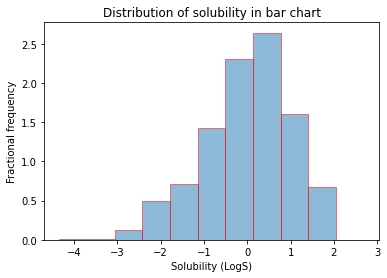

In [ ]:
#Check the distribution of solubility of training set using bar chart.

Y_train_min = min(Y_trainset)
Y_train_max = max(Y_trainset)
nbin = 10
sbin = (Y_train_max - Y_train_min) / nbin
boundary = np.arange(Y_train_min - 0.001, Y_train_max, sbin)
hist = np.zeros(nbin + 1)
for i in Y_trainset:
  whichbin = np.max(np.where(i > boundary))
  hist[whichbin] = hist[whichbin] + 1

#Show fractional freq actually.

hist = np.divide(np.dot(hist, nbin), Y_trainset.shape[0])
sns.reset_orig()
plt.figure()
plt.bar(boundary + 0.5 * sbin, hist, width = sbin, align='center', alpha=0.5, edgecolor = 'red')
plt.xlabel('Solubility (LogS)')
plt.ylabel('Fractional frequency')
plt.title('Distribution of solubility in bar chart')
plt.show()

In [ ]:
#Train ridge regression model. Hypertune alpha, the regularization coeff, and it turns out that alpha = 15.6 is the best one.

ridge_model = Ridge(random_state = 1)
alphas = {'alpha' : list(10**np.linspace(4, -4, 100)*0.5)}
cv = KFold(n_splits = 10, shuffle = True, random_state = 1)
ridge_grid = GridSearchCV(ridge_model, param_grid = alphas, cv = cv, scoring = 'neg_mean_squared_error')
ridge_grid.fit(X_trainset, Y_trainset)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Ridge(random_state=1),
             param_grid={'alpha': [5000.0, 4151.087840659872,
                                   3446.3060521748475, 2861.1838296751102,
                                   2375.405081051399, 1972.103029718828,
                                   1637.2745814388643, 1359.29412136647,
                                   1128.5098598169595, 936.9087114301915,
                                   777.8380719652362, 645.774832507442,
                                   536.1336110051616, 445.10754272251916,
                                   369.53610167628875, 306.7953636706588,
                                   254.70690074081875, 211.46214371947494,
                                   175.55958671075655, 145.75265314125878,
                                   121.00641323971905, 100.46165012825229,
                                   83.40502686000296, 69.24431856969359,
             

{'alpha': 15.628579248441175}


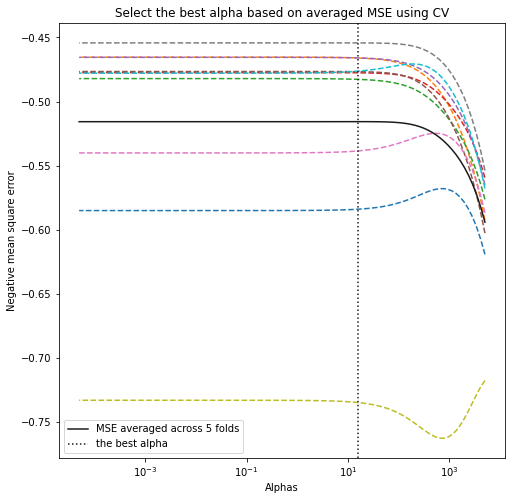

In [ ]:
#Visualize how the alpha is selected based on the scoring standard, negative mse.

print(ridge_grid.best_params_)
cv_result1 = pd.DataFrame(ridge_grid.cv_results_)
mean_test_scores = cv_result1['mean_test_score']
test_scores = cv_result1[['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score'
                          , 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score']]
plt.figure(figsize= (8, 8))
plt.semilogx(alphas['alpha'], test_scores, linestyle = "--")
plt.plot(alphas['alpha'], mean_test_scores, 
         color = 'k', label = "MSE averaged across 5 folds")
plt.axvline(cv_result1['param_alpha'][cv_result1['mean_test_score'].idxmax()], color = 'k', linestyle =  ':', label = "the best alpha")
plt.legend()
plt.xlabel("Alphas")
plt.ylabel("Negative mean square error")
plt.title("Select the best alpha based on averaged MSE using CV")
plt.show()

In [ ]:
#Accuracy of ridge regression model based on prediction results on testset.

ridge_model_chosen = Ridge(alpha = cv_result1['param_alpha'][cv_result1['mean_test_score'].idxmax()], random_state = 1).fit(X_trainset, Y_trainset)
pred_results = ridge_model_chosen.predict(X_testset)

print("MSE:{:.2f}".format(mean_squared_error(Y_testset, pred_results)))
print("RMSE:{:.2f}".format(mean_squared_error(Y_testset, pred_results, squared = False)))
print("MAE:{:.2f}".format(mean_absolute_error(Y_testset, pred_results)))
print("R2 SQUARE:{:.2f}".format(r2_score(Y_testset, pred_results)))

MSE:0.57
RMSE:0.75
MAE:0.53
R2 SQUARE:0.43


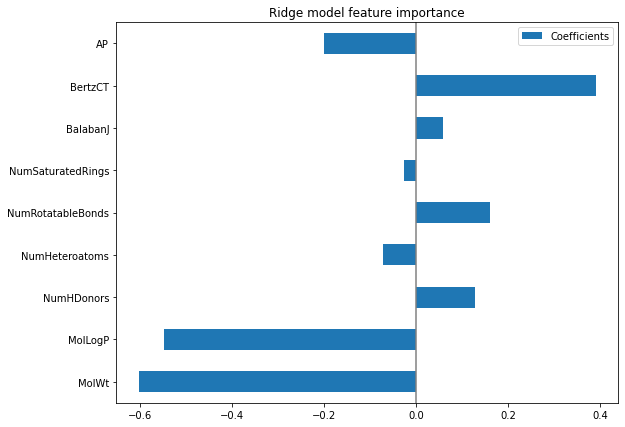

In [ ]:
#Which features contribute most to the modeling?
#MolWt, MolLogP, BertzCT, and AP are the top 4 important features.

ridge_features = pd.DataFrame(ridge_model_chosen.coef_, columns=['Coefficients'], index = cols[1:])
ridge_features.plot(kind = 'barh', figsize=(9, 7))
plt.title('Ridge model feature importance')
plt.axvline(x = 0, color = '.5')
plt.show()

In [ ]:
#Pick 10 obs from testset randomly and show the true solubility vs predicted solubility for comparison.

np.random.seed(0)
test_selected = df.loc[list(test_indices['index'].sample(n = 10).to_numpy())]
test_demo = test_selected[['Solubility']].reset_index(drop = True)
test_selected_scaled = scaler2.transform(test_selected[cols[1:]])
test_selected_pred = pd.DataFrame(ridge_model_chosen.predict(test_selected_scaled), columns = ['Solubility (Predicted)'])
test_selected_pred = test_selected_pred*Y_std + Y_mean
test_demo.merge(test_selected_pred, left_index = True, right_index = True)

,Solubility,Solubility (Predicted)
0,-2.254040,-0.174081
1,-2.830000,-2.512799
2,-0.267800,-2.133198
3,-2.180000,-2.547522
4,-4.210700,-4.318822
5,-2.980000,-3.582801
6,-1.373368,-2.963804
7,-2.413500,-2.236609
8,-8.603600,-6.267225
9,-6.656649,-4.468943


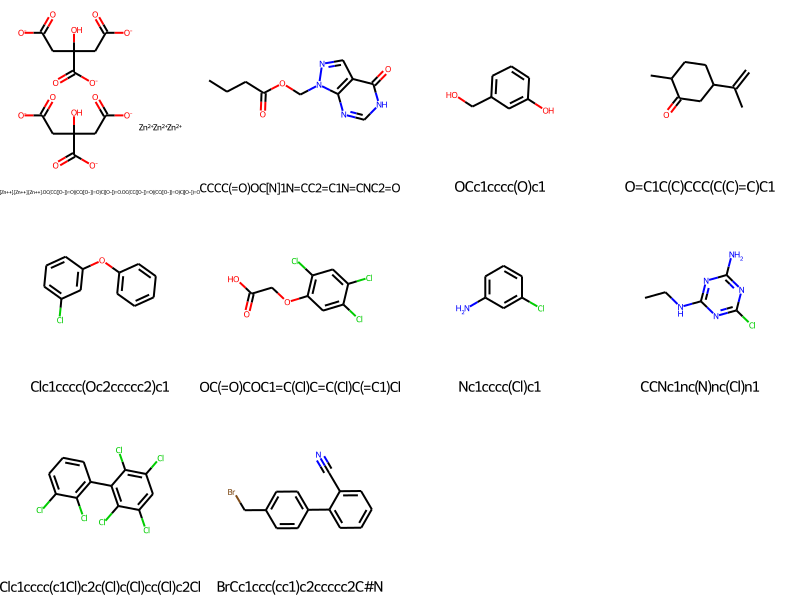

In [ ]:
#Show the structures of the 10 obs.
#The 1st and 3rd ones are tricarboxylic acids and phenol-methyl-alcohol, respectively. They should be more soluable relative to the others.
#However, the ridge model does not predict the results well.
#Need to use other non-linear models later.

test_chem_demo = test_selected.loc[:, ['SMILES']]
test_chem_demo['MOL'] = test_chem_demo['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
Draw.MolsToGridImage(test_chem_demo['MOL'], molsPerRow = 4, useSVG = True, legends = list(test_chem_demo['SMILES'].values)) 

In [ ]:
#Train support vector regression model. Hypertune gamma, kernel coeff (bandwidth),
#and C, the regularization coeff, and it turns out that gamma = 0.35, C= 4 are the best.

SVR_model = SVR(kernel = 'rbf')
params = {'gamma': [0.2, 0.25, 0.3, 0.35, 0.4, 0.5], 'C':[2, 3, 4, 5, 6]}
cv = KFold(n_splits = 10, shuffle = True, random_state = 1)
SVR_grid = GridSearchCV(SVR_model, param_grid = params, cv = cv, scoring = 'neg_mean_squared_error')
SVR_grid.fit(X_trainset, Y_trainset)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [2, 3, 4, 5, 6],
                         'gamma': [0.2, 0.25, 0.3, 0.35, 0.4, 0.5]},
             scoring='neg_mean_squared_error')

{'C': 4, 'gamma': 0.35}


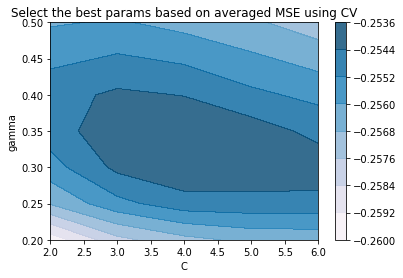

In [ ]:
#Visualize how C and gamma are selected based on the scoring standard, negative mse.
#Note that we cannot show feature importance for SVR model since we used non-linear rbf kernel.

print(SVR_grid.best_params_)
cv_result2 = pd.DataFrame(SVR_grid.cv_results_)
cv_result2_reset = cv_result2[['param_C', 'param_gamma', 'mean_test_score']]
cv_result2_pivot = cv_result2_reset.pivot('param_C', 'param_gamma')
fig, ax = plt.subplots()
X = cv_result2_pivot.columns.levels[1].values
Y = cv_result2_pivot.index.values
Z = cv_result2_pivot.values
Xi, Yi = np.meshgrid(X, Y)
cs = plt.contourf(Yi, Xi, Z, alpha = 0.8, cmap = plt.cm.PuBu)
cbar = fig.colorbar(cs)
plt.xlabel("C")
plt.ylabel("gamma")
plt.title("Select the best params based on averaged MSE using CV")
plt.show()

In [ ]:
#Accuracy of support vector regression model based on prediction results on testset. Much better than ridge regression.

SVR_model_chosen = SVR_grid.best_estimator_
pred_results2 = SVR_model_chosen.predict(X_testset)

print("MSE:{:.2f}".format(mean_squared_error(Y_testset, pred_results2)))
print("RMSE:{:.2f}".format(mean_squared_error(Y_testset, pred_results2, squared = False)))
print("MAE:{:.2f}".format(mean_absolute_error(Y_testset, pred_results2)))
print("R2 SQUARE:{:.2f}".format(r2_score(Y_testset, pred_results2)))

MSE:0.26
RMSE:0.51
MAE:0.35
R2 SQUARE:0.74


In [ ]:
#Pick 10 obs from testset randomly and show the true solubility vs predicted solubility for comparison.

np.random.seed(0)
test_selected = df.loc[list(test_indices['index'].sample(n = 10).to_numpy())]
test_demo = test_selected[['Solubility']].reset_index(drop = True)
test_selected_scaled = scaler2.transform(test_selected[cols[1:]])
test_selected_pred = pd.DataFrame(SVR_model_chosen.predict(test_selected_scaled), columns = ['Solubility (Predicted)'])
test_selected_pred = test_selected_pred*Y_std + Y_mean
test_demo.merge(test_selected_pred, left_index = True, right_index = True)

,Solubility,Solubility (Predicted)
0,-2.254040,-1.627407
1,-2.830000,-2.239638
2,-0.267800,-0.396142
3,-2.180000,-2.828706
4,-4.210700,-4.880468
5,-2.980000,-3.304377
6,-1.373368,-1.116956
7,-2.413500,-1.671794
8,-8.603600,-8.016653
9,-6.656649,-4.921006


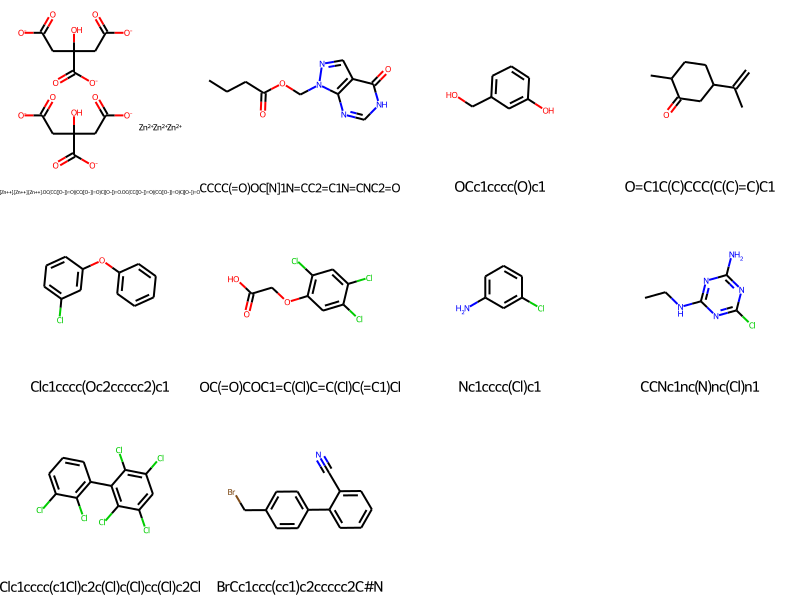

In [ ]:
#Show the structures of the 10 obs.
#The 1st and 3rd ones are tricarboxylic acids and phenol-methyl-alcohol, respectively. They should be more soluable relative to the others.
#Predictions of SVR are much improved relative to ridge.

test_chem_demo = test_selected.loc[:, ['SMILES']]
test_chem_demo['MOL'] = test_chem_demo['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
Draw.MolsToGridImage(test_chem_demo['MOL'], molsPerRow = 4, useSVG = True, legends = list(test_chem_demo['SMILES'].values)) 

In [ ]:
#Pick another 10 obs.
#The last one should be more soluable. The 3rd one should be very insoluable.
#They are predicted accurately to some level by SVR model.

np.random.seed(777)
test_selected = df.loc[list(test_indices['index'].sample(n = 10).to_numpy())]
test_demo = test_selected[['Solubility']].reset_index(drop = True)
test_selected_scaled = scaler2.transform(test_selected[cols[1:]])
test_selected_pred = pd.DataFrame(SVR_model_chosen.predict(test_selected_scaled), columns = ['Solubility (Predicted)'])
test_selected_pred = test_selected_pred*Y_std + Y_mean
test_demo.merge(test_selected_pred, left_index = True, right_index = True)

,Solubility,Solubility (Predicted)
0,-0.860000,-1.937546
1,-8.176000,-7.432250
2,-8.333900,-6.359025
3,-1.517100,-3.378083
4,-2.370000,-1.827546
5,-2.528300,-1.333577
6,-2.779325,-2.343701
7,-3.269616,-3.081260
8,-4.860000,-4.649680
9,-0.057000,-0.575554


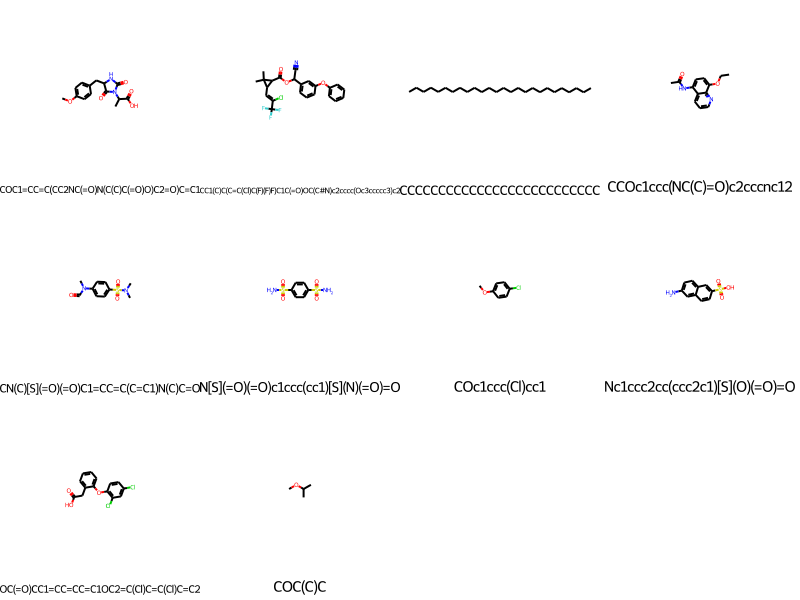

In [ ]:
#Show the structures of the 10 obs.

test_chem_demo = test_selected.loc[:, ['SMILES']]
test_chem_demo['MOL'] = test_chem_demo['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
Draw.MolsToGridImage(test_chem_demo['MOL'], molsPerRow = 4, useSVG = True, legends = list(test_chem_demo['SMILES'].values)) 

In [ ]:
#Train regression tree model. Hypertune ccp_alpha, pruning coeff,
#and min_impurity_decrease, and it turns out that both of them = 0.000834 are the best.

tree_model = DecisionTreeRegressor(random_state = 1)
#path = tree_model.cost_complexity_pruning_path(X_trainset, Y_trainset)
params = {'ccp_alpha' : list(10**np.linspace(-1, -5, 10)*0.5), 'min_impurity_decrease':list(10**np.linspace(-1, -5, 10)*0.5)}
cv = KFold(n_splits = 10, shuffle = True, random_state = 1)
tree_grid = GridSearchCV(tree_model, param_grid = params, cv = cv, scoring = 'neg_mean_squared_error')
tree_grid.fit(X_trainset, Y_trainset)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=1),
             param_grid={'ccp_alpha': [0.05, 0.01796906831902314,
                                       0.00645774832507442,
                                       0.002320794416806391,
                                       0.0008340502686000296,
                                       0.00029974212515947044,
                                       0.00010772173450159422,
                                       3.871318413405639e-05,
                                       1.391279701103563e-05, 5e-06],
                         'min_impurity_decrease': [0.05, 0.01796906831902314,
                                                   0.00645774832507442,
                                                   0.002320794416806391,
                                                   0.0008340502686000296,
                                                   0.000299742125159

{'ccp_alpha': 0.0008340502686000296, 'min_impurity_decrease': 0.0008340502686000296}


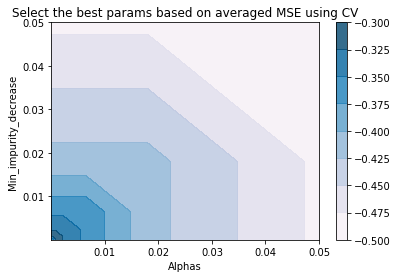

In [ ]:
#Visualize how ccp_alpha and min_impurity_decrease are selected based on the scoring standard, negative mse.

print(tree_grid.best_params_)
cv_result3 = pd.DataFrame(tree_grid.cv_results_)
cv_result3_reset = cv_result3[['param_ccp_alpha', 'param_min_impurity_decrease', 'mean_test_score']]
cv_result3_pivot = cv_result3_reset.pivot('param_ccp_alpha', 'param_min_impurity_decrease')
fig, ax = plt.subplots()
X = cv_result3_pivot.columns.levels[1].values
Y = cv_result3_pivot.index.values
Z = cv_result3_pivot.values
Xi, Yi = np.meshgrid(X, Y)
cs = plt.contourf(Yi, Xi, Z, alpha = 0.8, cmap = plt.cm.PuBu)
cbar = fig.colorbar(cs)
plt.xlabel("Alphas")
plt.ylabel("Min_impurity_decrease")
plt.title("Select the best params based on averaged MSE using CV")
plt.show()

In [ ]:
#Accuracy of regression tree model based on prediction results on testset. Better than ridge regression.

tree_model_chosen = tree_grid.best_estimator_
tree_model_chosen.fit(X_trainset, Y_trainset)
pred_results3 = tree_model_chosen.predict(X_testset)

print("MSE:{:.2f}".format(mean_squared_error(Y_testset, pred_results3)))
print("RMSE:{:.2f}".format(mean_squared_error(Y_testset, pred_results3, squared = False)))
print("MAE:{:.2f}".format(mean_absolute_error(Y_testset, pred_results3)))
print("R2 SQUARE:{:.2f}".format(r2_score(Y_testset, pred_results3)))

MSE:0.28
RMSE:0.53
MAE:0.39
R2 SQUARE:0.72


In [ ]:
#Which features contribute most to the modeling?
#Being different from ridge, MolLogP, BertzCT, BalabanJ, and MolWt are the top 4 important features.

tree_features = pd.DataFrame({'Feature_names': cols[1:], 'Importances': tree_model_chosen.feature_importances_})
tree_features = tree_features.sort_values(by = 'Importances', ascending = False)
tree_features

,Feature_names,Importances
1,MolLogP,0.833021
7,BertzCT,0.094212
6,BalabanJ,0.022352
0,MolWt,0.020192
4,NumRotatableBonds,0.013121
2,NumHDonors,0.011365
3,NumHeteroatoms,0.005738
5,NumSaturatedRings,0.000000
8,AP,0.000000


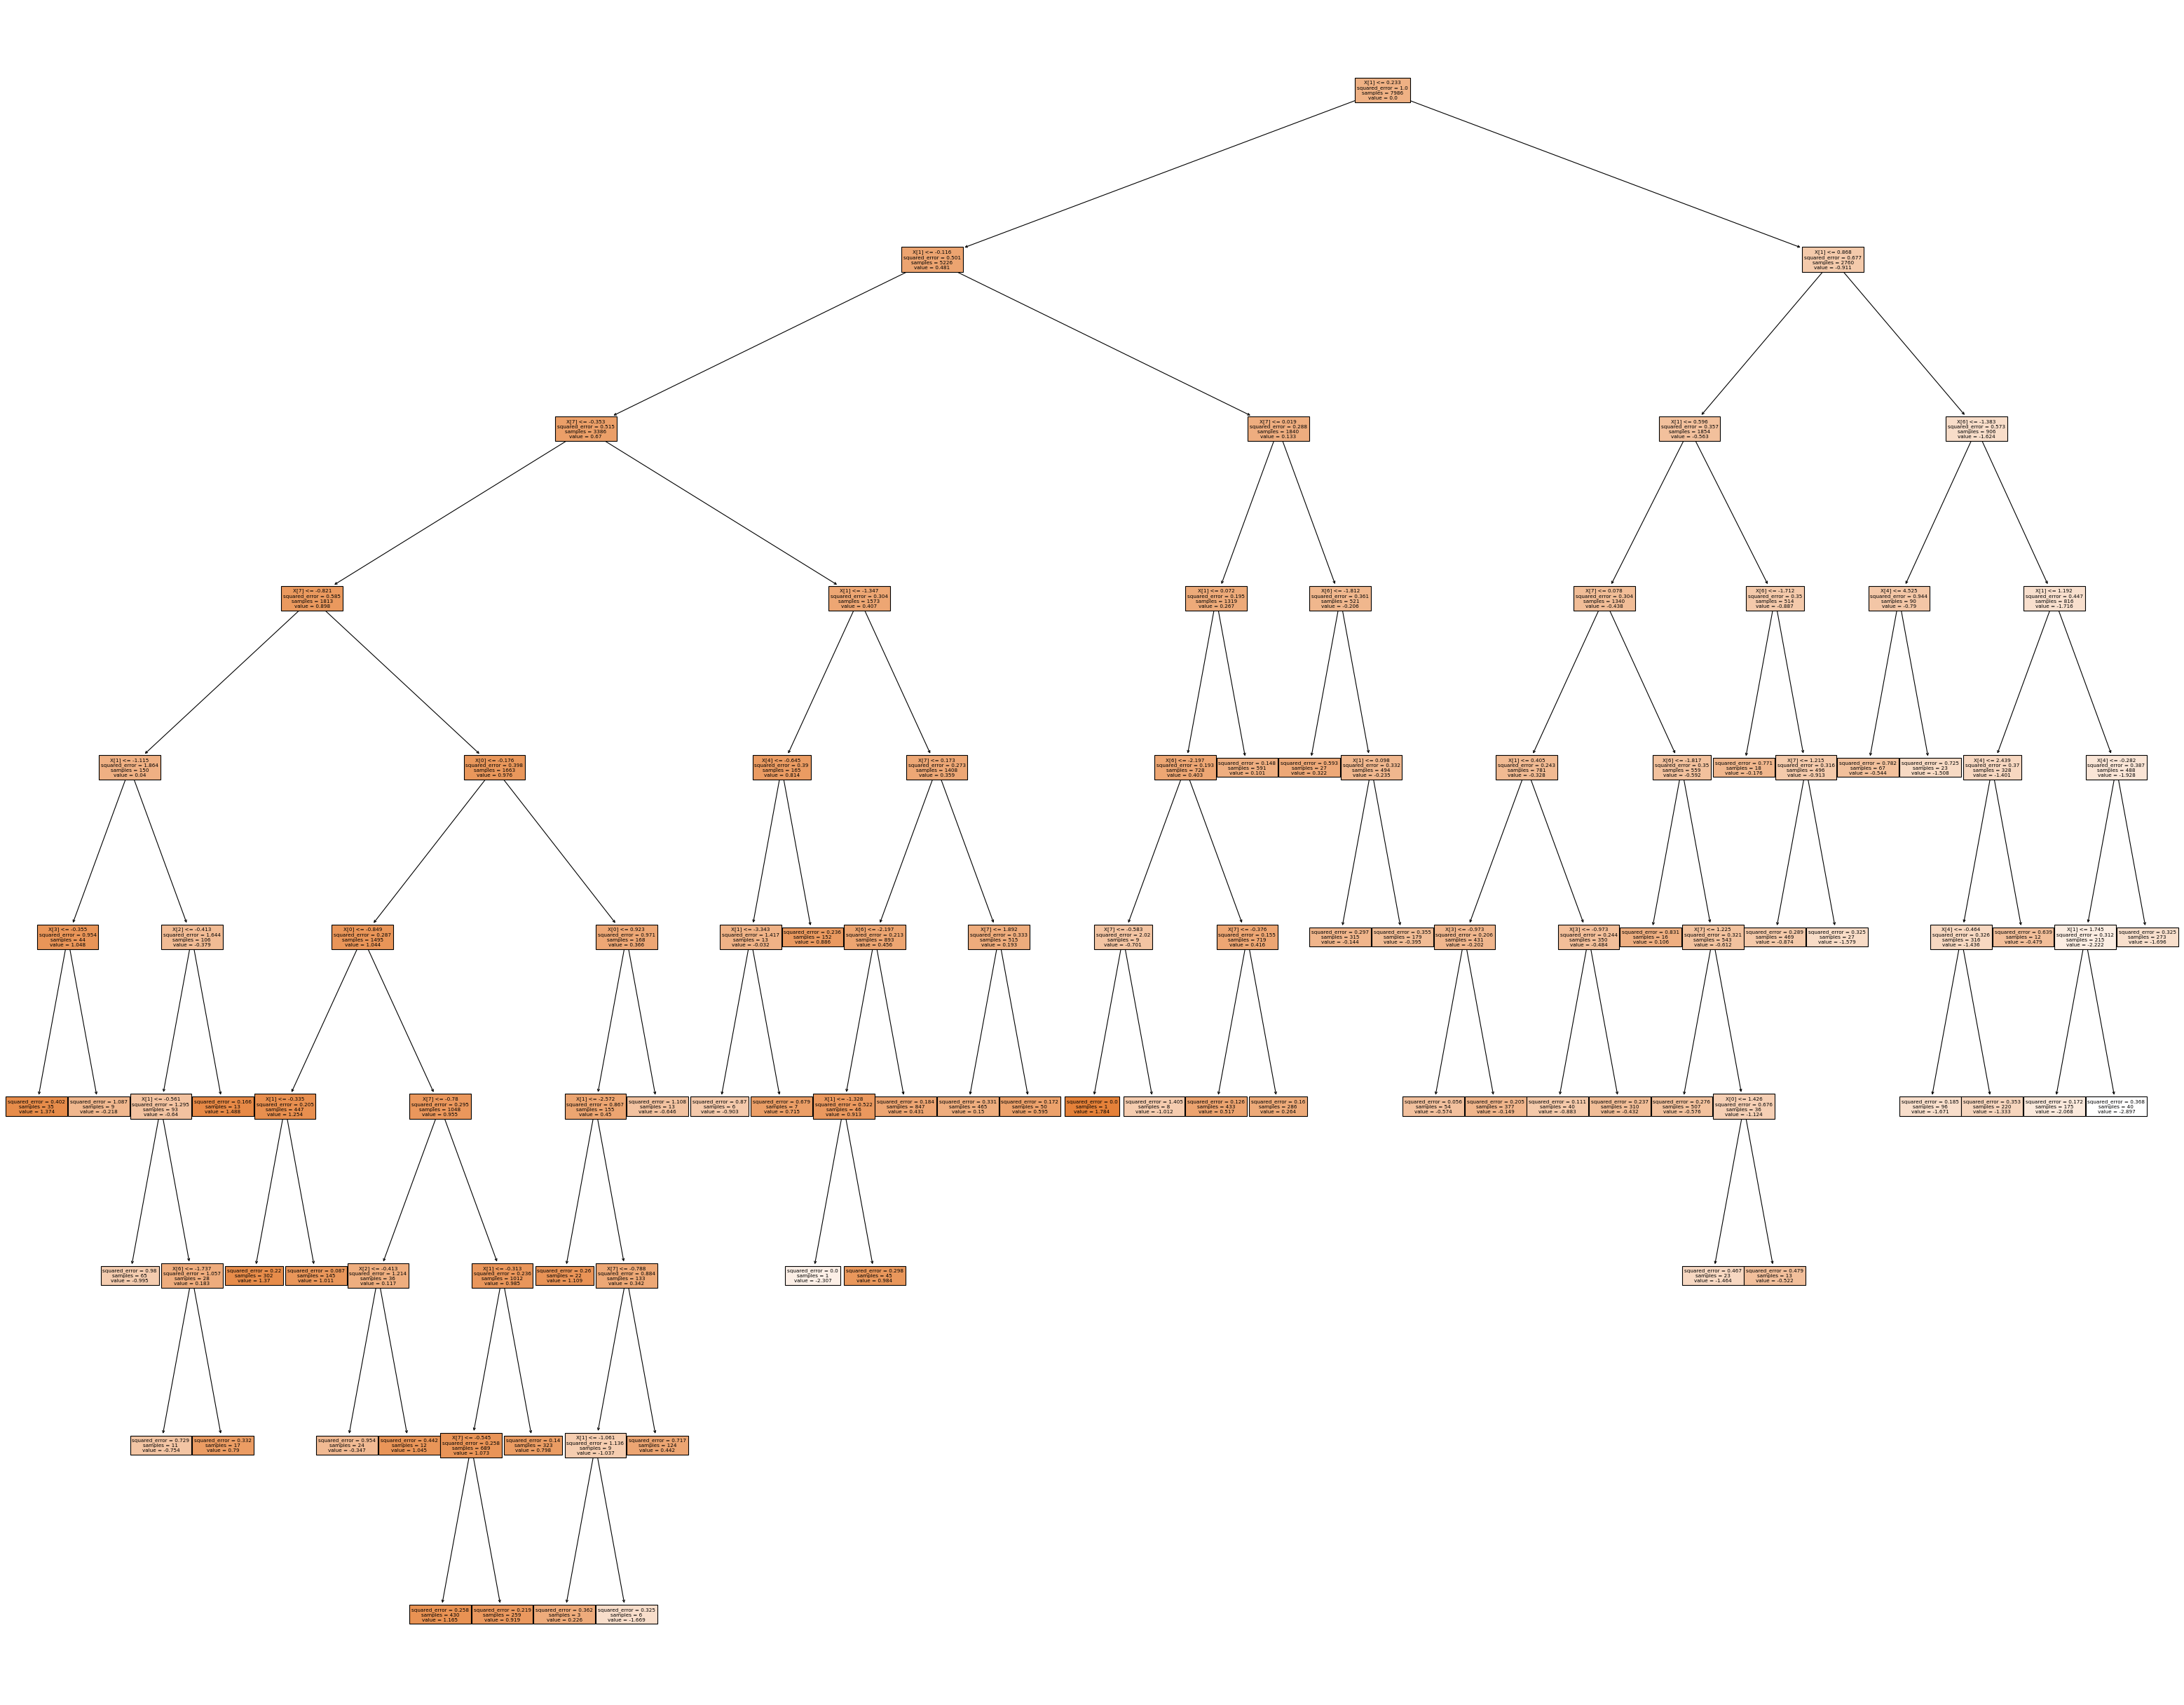

In [ ]:
#Show the tree.

plt.figure(figsize = (50, 40), dpi = 80)
plot_tree(tree_model_chosen, filled = True)
plt.show()

In [ ]:
#Pick 10 obs from testset randomly and show the true solubility vs predicted solubility for comparison.

np.random.seed(0)
test_selected = df.loc[list(test_indices['index'].sample(n = 10).to_numpy())]
test_demo = test_selected[['Solubility']].reset_index(drop = True)
test_selected_scaled = scaler2.transform(test_selected[cols[1:]])
test_selected_pred = pd.DataFrame(tree_model_chosen.predict(test_selected_scaled), columns = ['Solubility (Predicted)'])
test_selected_pred = test_selected_pred*Y_std + Y_mean
test_demo.merge(test_selected_pred, left_index = True, right_index = True)

,Solubility,Solubility (Predicted)
0,-2.254040,-0.794291
1,-2.830000,-2.540081
2,-0.267800,-1.002619
3,-2.180000,-2.656188
4,-4.210700,-4.966937
5,-2.980000,-3.247329
6,-1.373368,-1.669961
7,-2.413500,-0.717521
8,-8.603600,-7.796376
9,-6.656649,-4.966937


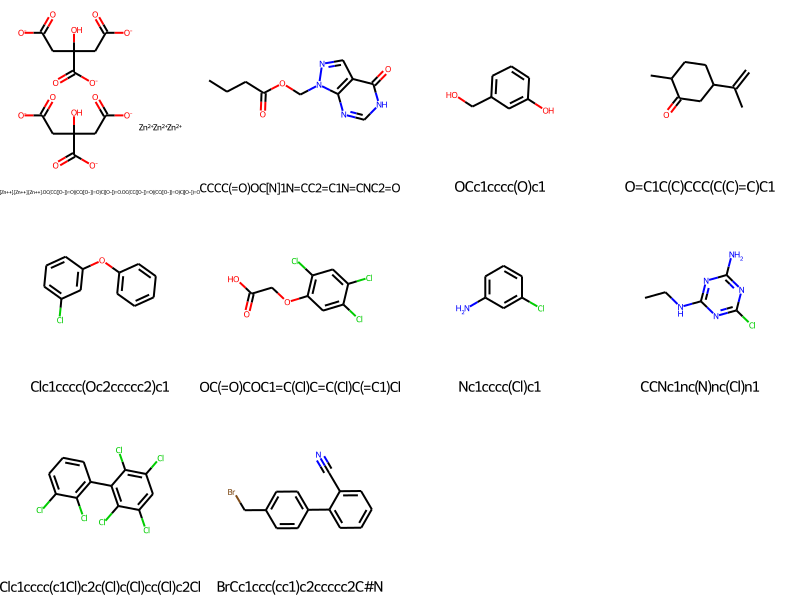

In [ ]:
#Show the structures of the 10 obs.
#The 1st and 3rd ones are tricarboxylic acids and phenol-methyl-alcohol, respectively. They should be more soluable relative to the others.
#Predictions of tree are somehow improved relative to ridge.

test_chem_demo = test_selected.loc[:, ['SMILES']]
test_chem_demo['MOL'] = test_chem_demo['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
Draw.MolsToGridImage(test_chem_demo['MOL'], molsPerRow = 4, useSVG = True, legends = list(test_chem_demo['SMILES'].values)) 

In [ ]:
#Train random forest model. Hypertune ccp_alpha, pruning coeff,
#and min_impurity_decrease, and it turns out that ccp_alpha = 4.6415888336127725e-07 and min_impurity_decrease =  3.593813663804626e-08 are the best.

forest_model = RandomForestRegressor(random_state = 1)
params = {'ccp_alpha': list(10**np.linspace(-3, -8, 10)), 
          'min_impurity_decrease':list(10**np.linspace(-3, -8, 10))}
cv = KFold(n_splits = 10, shuffle = True, random_state = 1)
forest_grid = GridSearchCV(forest_model, param_grid = params, cv = cv, scoring = 'neg_mean_squared_error')
forest_grid.fit(X_trainset, Y_trainset)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(random_state=1),
             param_grid={'ccp_alpha': [0.001, 0.0002782559402207126,
                                       7.742636826811278e-05,
                                       2.1544346900318823e-05,
                                       5.994842503189409e-06,
                                       1.6681005372000591e-06,
                                       4.6415888336127725e-07,
                                       1.2915496650148827e-07,
                                       3.593813663804626e-08, 1e-08],
                         'min_impurity_decrease': [0.001, 0.0002782559402207126,
                                                   7.742636826811278e-05,
                                                   2.1544346900318823e-05,
                                                   5.994842503189409e-06,
                                                   1.

In [ ]:
forest_grid.best_params_

{'ccp_alpha': 4.6415888336127725e-07,
 'min_impurity_decrease': 3.593813663804626e-08}

In [ ]:
#Hypertune n_estimators.

forest_model1 = forest_grid.best_estimator_
params = {'n_estimators': list(range(2, 101))}
cv = KFold(n_splits = 10, shuffle = True, random_state = 1)
forest_grid1 = GridSearchCV(forest_model1, param_grid = params, cv = cv, scoring = 'neg_mean_squared_error')
forest_grid1.fit(X_trainset, Y_trainset)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(ccp_alpha=4.6415888336127725e-07,
                                             min_impurity_decrease=3.593813663804626e-08,
                                             random_state=1),
             param_grid={'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30,
                                          31, ...]},
             scoring='neg_mean_squared_error')

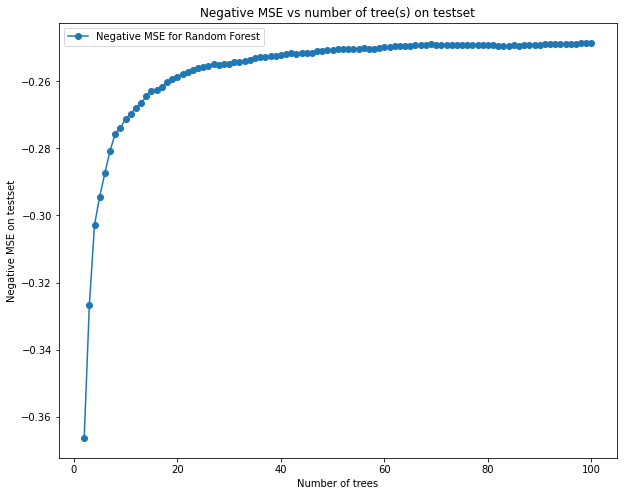

In [ ]:
#Visualize how n_estimators is selected based on the scoring standard, negative mse.

fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(range(2, 101), forest_grid1.cv_results_['mean_test_score'], marker="o", label = 'Negative MSE for Random Forest')
ax.legend()
ax.set_xlabel("Number of trees")
ax.set_ylabel("Negative MSE on testset")
ax.set_title("Negative MSE vs number of tree(s) on testset")
plt.show()

In [ ]:
#Accuracy of forest model based on prediction results on testset. The best so far.

forest_model_chosen = forest_grid1.best_estimator_
forest_model_chosen.fit(X_trainset, Y_trainset)
pred_results4 = forest_model_chosen.predict(X_testset)

print("MSE:{:.2f}".format(mean_squared_error(Y_testset, pred_results4)))
print("RMSE:{:.2f}".format(mean_squared_error(Y_testset, pred_results4, squared = False)))
print("MAE:{:.2f}".format(mean_absolute_error(Y_testset, pred_results4)))
print("R2 SQUARE:{:.2f}".format(r2_score(Y_testset, pred_results4)))

MSE:0.22
RMSE:0.47
MAE:0.32
R2 SQUARE:0.78


In [ ]:
#Which features contribute most to the modeling?
#Being different from ridge, MolLogP, BertzCT, BalabanJ, and MolWt are the top 4 important features.

forest_features = pd.DataFrame({'Feature_names': cols[1:], 'Importances': forest_model_chosen.feature_importances_})
forest_features = forest_features.sort_values(by = 'Importances', ascending = False)
forest_features

,Feature_names,Importances
1,MolLogP,0.661889
7,BertzCT,0.112297
0,MolWt,0.069203
6,BalabanJ,0.057145
4,NumRotatableBonds,0.030904
3,NumHeteroatoms,0.029756
2,NumHDonors,0.017589
8,AP,0.016685
5,NumSaturatedRings,0.004533


In [ ]:
#Pick 10 obs from testset randomly and show the true solubility vs predicted solubility for comparison.

np.random.seed(0)
test_selected = df.loc[list(test_indices['index'].sample(n = 10).to_numpy())]
test_demo = test_selected[['Solubility']].reset_index(drop = True)
test_selected_scaled = scaler2.transform(test_selected[cols[1:]])
test_selected_pred = pd.DataFrame(forest_model_chosen.predict(test_selected_scaled), columns = ['Solubility (Predicted)'])
test_selected_pred = test_selected_pred*Y_std + Y_mean
test_demo.merge(test_selected_pred, left_index = True, right_index = True)

,Solubility,Solubility (Predicted)
0,-2.254040,-1.184631
1,-2.830000,-2.114220
2,-0.267800,-0.818179
3,-2.180000,-2.193288
4,-4.210700,-4.845458
5,-2.980000,-3.008976
6,-1.373368,-1.399091
7,-2.413500,-1.114280
8,-8.603600,-8.132442
9,-6.656649,-4.776729


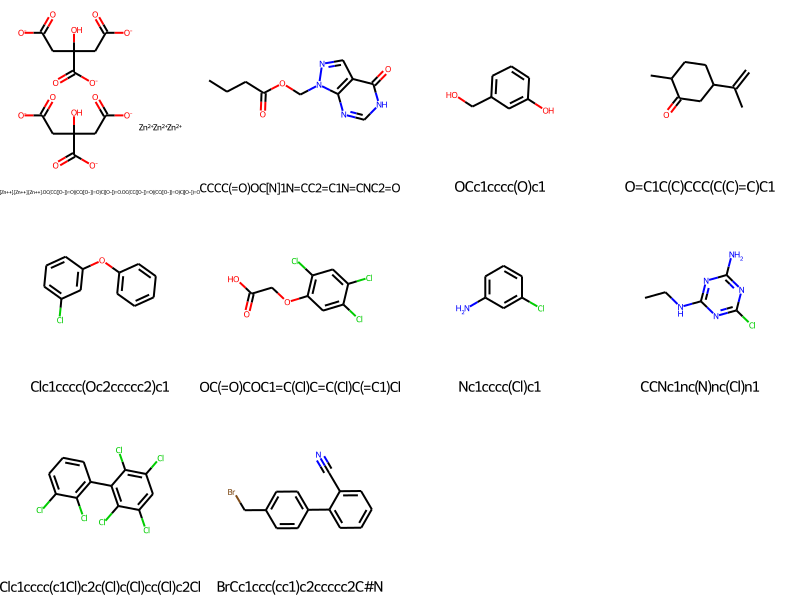

In [ ]:
#Show the structures of the 10 obs.
#The 1st and 3rd ones are tricarboxylic acids and phenol-methyl-alcohol, respectively. They should be more soluable relative to the others.
#Predictions of tree are much improved relative to the others.

test_chem_demo = test_selected.loc[:, ['SMILES']]
test_chem_demo['MOL'] = test_chem_demo['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
Draw.MolsToGridImage(test_chem_demo['MOL'], molsPerRow = 4, useSVG = True, legends = list(test_chem_demo['SMILES'].values)) 

In [ ]:
#Pick another 10 obs.
#The 6th and 9th ones should be more soluable.
#They are predicted accurately to some level by forest model.

np.random.seed(100)
test_selected = df.loc[list(test_indices['index'].sample(n = 10).to_numpy())]
test_demo = test_selected[['Solubility']].reset_index(drop = True)
test_selected_scaled = scaler2.transform(test_selected[cols[1:]])
test_selected_pred = pd.DataFrame(forest_model_chosen.predict(test_selected_scaled), columns = ['Solubility (Predicted)'])
test_selected_pred = test_selected_pred*Y_std + Y_mean
test_demo.merge(test_selected_pred, left_index = True, right_index = True)

,Solubility,Solubility (Predicted)
0,-4.900000,-4.910333
1,-5.950428,-5.610828
2,-1.847136,-3.133563
3,-4.325100,-4.145902
4,-1.735600,-1.856801
5,0.221876,-0.788212
6,-0.768400,-0.338107
7,-7.692243,-7.781895
8,1.124515,1.028833
9,-2.900000,-3.309299


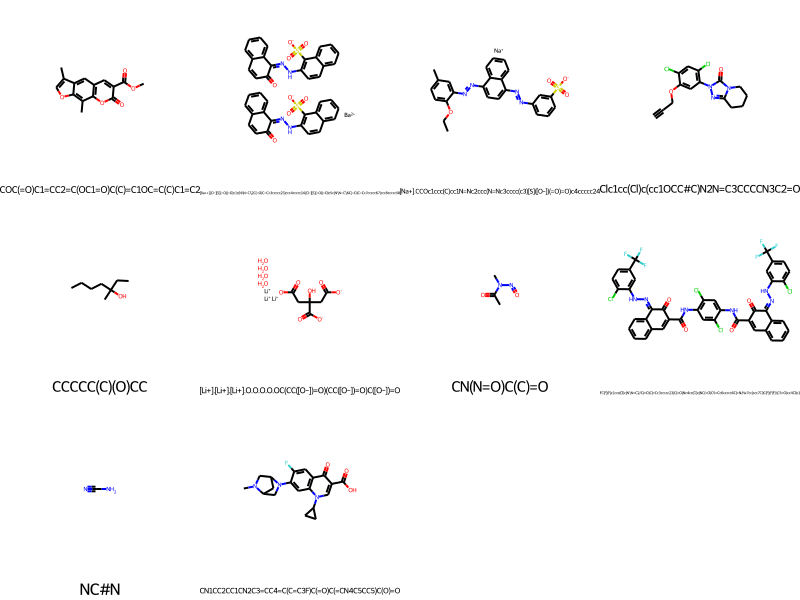

In [ ]:
#Show the structures of the 10 obs.

test_chem_demo = test_selected.loc[:, ['SMILES']]
test_chem_demo['MOL'] = test_chem_demo['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
Draw.MolsToGridImage(test_chem_demo['MOL'], molsPerRow = 4, useSVG = True, legends = list(test_chem_demo['SMILES'].values)) 

In [ ]:
#Build up the NN model using Keras. Use kernel initializer as normal and activation function as relu. 
#Need to hyertune the dropout rate for the 2nd and 3rd layers.

def build_model(dropout_rate = 0.0):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim = X_trainset.shape[1], kernel_initializer='normal'))
    model.add(Dense(64, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return model

In [ ]:
#Train NN model. Hypertune dropout rate, epochs, and batch_size.

np.random.seed(1)
NN_model = KerasRegressor(build_fn = build_model, epochs = 1000, batch_size = 1000, verbose=0)
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4]
epochs= [50, 100, 200, 500, 1000]
batch_size = list(range(1000, X_trainset.shape[0] + 1, int(X_trainset.shape[0]/5)))
params = dict(dropout_rate = dropout_rate, epochs = epochs, batch_size = batch_size)
cv = KFold(n_splits = 10, shuffle = True, random_state = 1)
NN_grid = GridSearchCV(estimator = NN_model, cv = cv, param_grid = params, n_jobs = -1)
NN_grid.fit(X_trainset, Y_trainset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f7f9b8a7590>,
             n_jobs=-1,
             param_grid={'batch_size': [1000, 2597, 4194, 5791, 7388],
                         'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'epochs': [50, 100, 200, 500, 1000]})

In [ ]:
#Accuracy of NN model based on prediction results on testset. Much better than ridge regression.

NN_model_chosen = NN_grid.best_estimator_
NN_model_chosen.fit(X_trainset, Y_trainset)
pred_results5 = NN_model_chosen.predict(X_testset)
print("MSE:{:.2f}".format(mean_squared_error(Y_testset, pred_results5)))
print("RMSE:{:.2f}".format(mean_squared_error(Y_testset, pred_results5, squared = False)))
print("MAE:{:.2f}".format(mean_absolute_error(Y_testset, pred_results5)))
print("R2 SQUARE:{:.2f}".format(r2_score(Y_testset, pred_results5)))

MSE:0.25
RMSE:0.50
MAE:0.36
R2 SQUARE:0.74


In [ ]:
NN_grid.best_params_

{'batch_size': 2597, 'dropout_rate': 0.3, 'epochs': 1000}

In [ ]:
#Pick 10 obs from testset randomly and show the true solubility vs predicted solubility for comparison.

np.random.seed(0)
test_selected = df.loc[list(test_indices['index'].sample(n = 10).to_numpy())]
test_demo = test_selected[['Solubility']].reset_index(drop = True)
test_selected_scaled = scaler2.transform(test_selected[cols[1:]])
test_selected_pred = pd.DataFrame(NN_model_chosen.predict(test_selected_scaled), columns = ['Solubility (Predicted)'])
test_selected_pred = test_selected_pred*Y_std + Y_mean
test_demo.merge(test_selected_pred, left_index = True, right_index = True)

,Solubility,Solubility (Predicted)
0,-2.254040,-0.918356
1,-2.830000,-2.234715
2,-0.267800,-1.040553
3,-2.180000,-2.518211
4,-4.210700,-4.723382
5,-2.980000,-3.297097
6,-1.373368,-1.500882
7,-2.413500,-1.997971
8,-8.603600,-7.325043
9,-6.656649,-4.611500


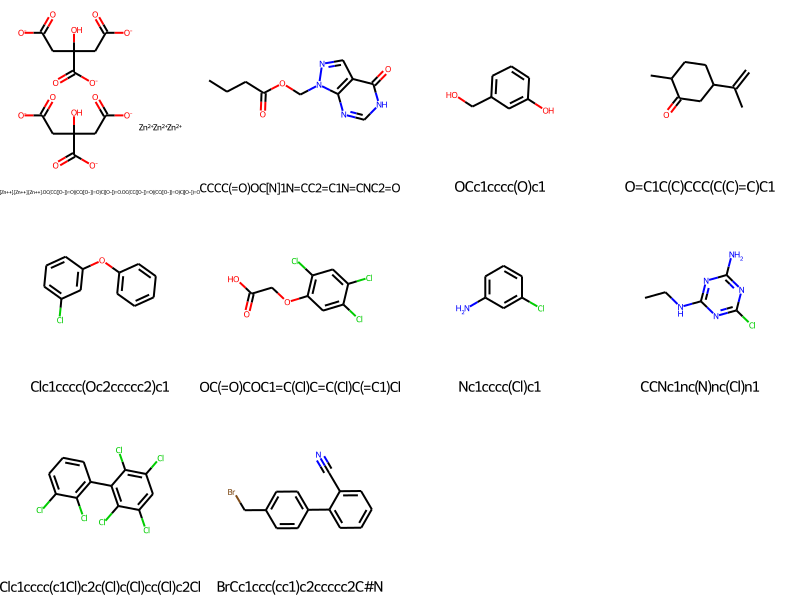

In [ ]:
#Show the structures of the 10 obs.
#The 1st and 3rd ones are tricarboxylic acids and phenol-methyl-alcohol, respectively. They should be more soluable relative to the others.
#Predictions of tree are somehow improved relative to ridge. NN predicts the 1st molecule to be soluable, which corresponds to what chemist 
#recognizes but different to the true solubility.

test_chem_demo = test_selected.loc[:, ['SMILES']]
test_chem_demo['MOL'] = test_chem_demo['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
Draw.MolsToGridImage(test_chem_demo['MOL'], molsPerRow = 4, useSVG = True, legends = list(test_chem_demo['SMILES'].values)) 

In [ ]:
#Pick another 10 obs.
#The 7th and 8th ones should be more soluable.
#They are not that accurate meaning the NN model needs to be improved.

np.random.seed(374)
test_selected = df.loc[list(test_indices['index'].sample(n = 10).to_numpy())]
test_demo = test_selected[['Solubility']].reset_index(drop = True)
test_selected_scaled = scaler2.transform(test_selected[cols[1:]])
test_selected_pred = pd.DataFrame(NN_model_chosen.predict(test_selected_scaled), columns = ['Solubility (Predicted)'])
test_selected_pred = test_selected_pred*Y_std + Y_mean
test_demo.merge(test_selected_pred, left_index = True, right_index = True)

,Solubility,Solubility (Predicted)
0,-0.800000,-3.276629
1,-0.204600,-1.199439
2,-3.230000,-3.115540
3,-3.550000,-4.933415
4,-0.864516,-1.187790
5,-0.170000,-1.272396
6,1.045169,-0.781946
7,0.523000,-2.074281
8,-0.930402,-2.437265
9,-1.270000,-4.156256


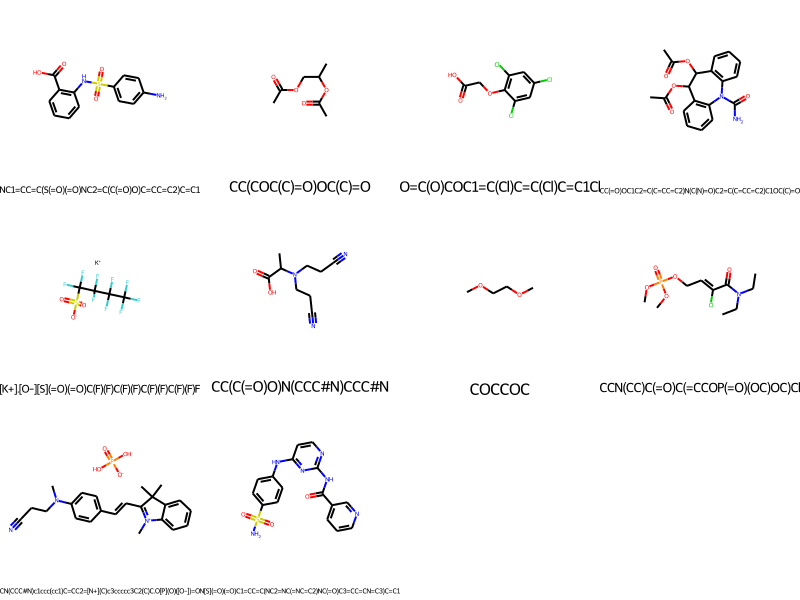

In [ ]:
#Show the structures of the 10 obs.

test_chem_demo = test_selected.loc[:, ['SMILES']]
test_chem_demo['MOL'] = test_chem_demo['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
Draw.MolsToGridImage(test_chem_demo['MOL'], molsPerRow = 4, useSVG = True, legends = list(test_chem_demo['SMILES'].values)) 

In [ ]:
#Conclusion:
#The aqueous solubility dataset, AqSolDB, was preprocessed by feature selection using prior knowledge and covar matrix/heatmap
#and scaled for both X and Y. After training testing splitting based on groups, the training set was fed to ridge, SVR, tree, forest and NN regression
#models with hypertuning. The prediction accuracy was demonstrated by MSE, RMSE and R2 metrics. The accuracy was further illustrated by 
#randomly picking up 10 obs from testing set, and comparing the predicted with true solubilities.
#It seems like that non-linear model, SVR, forest and NN are better than ridge and tree model. Forest model is the best in terms of MSE amoung them,
#but NN with furthher modification may outperform forest potentially.